In [ ]:
# This uses:
# ✔ Albumentations augmentation
# ✔ U-Net++ + EfficientNetB4 backbone
# ✔ DiceLoss + BCE
# ✔ CosineAnnealingLR scheduler
# ✔ 512×512 input images

**Improved U-Net++ Training Code**

In [ ]:
!pip install segmentation-models-pytorch albumentations==1.4.3 --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.5 MB/s eta 0:00:00


In [ ]:
# ===============================
# 2. IMPORTS
# ===============================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

base_path = "/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs/"

os.makedirs(base_path, exist_ok=True)

print("Folder checked/created:", base_path)

Folder checked/created: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs/


In [ ]:
# ===============================
# 3. DATASET CLASS
# ===============================
import os
import cv2
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, file_list, transforms=None, strict=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transforms = transforms
        self.strict = strict

        self.valid_files = []
        self.missing = []

        for f in self.file_list:
            img_path = os.path.join(self.img_dir, f)

            # convert name from .jpg → .png mask
            base = os.path.splitext(f)[0]
            mask_path = os.path.join(self.mask_dir, base + ".png")

            if os.path.isfile(img_path) and os.path.isfile(mask_path):
                self.valid_files.append(f)
            else:
                self.missing.append(f)
                if strict:
                    raise FileNotFoundError(f"Missing mask or image for file: {f}")

        if len(self.valid_files) == 0:
            raise ValueError("Dataset is empty after filtering.")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):

        # Correct file list variable
        f = self.valid_files[idx]
        base = os.path.splitext(f)[0]

        img = Image.open(os.path.join(self.img_dir, f)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, base + ".png"))

        img = np.array(img)
        mask = np.array(mask)

        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed["image"]          # already CHW torch tensor
            mask = transformed["mask"].long()   # already HW torch tensor
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).long()

        return img, mask

In [ ]:
# ===============================
# 4. AUGMENTATIONS
# ===============================
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    # Normalization depending on EfficientNet
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
import os

base = "/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs"

for root, dirs, files in os.walk(base):
    print(root)
    for d in dirs:
        print("   DIR:", d)
    for f in files:
        print("   FILE:", f)

/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs
   FILE: unetpp_training_history.csv


In [ ]:
# ===============================
# 5. LOAD DATA
# ===============================

base = "/content/drive/MyDrive/urine_uti/ml-services/kasundi/data/processed/wbc_detect"

def list_filenames(path):
    """Returns sorted file names only (no directories)."""
    return sorted([f for f in os.listdir(path)
                   if os.path.isfile(os.path.join(path, f))])

# ----- TRAIN -----
train_images = base + "/images/train"
train_masks  = base + "/masks/train"
train_files  = list_filenames(train_images)

train_dataset = SegmentationDataset(
    img_dir=train_images,
    mask_dir=train_masks,
    file_list=train_files,
    transforms=train_transform,
    strict=False,              # skip missing masks instead of crashing
)

# ----- VAL -----
val_images = base + "/images/val"
val_masks  = base + "/masks/val"
val_files  = list_filenames(val_images)

val_dataset = SegmentationDataset(
    img_dir=val_images,
    mask_dir=val_masks,
    file_list=val_files,
    transforms=val_transform,
    strict=False,
)

# ----- TEST -----
test_images = base + "/images/test"
test_masks  = base + "/masks/test"
test_files  = list_filenames(test_images)

test_dataset = SegmentationDataset(
    img_dir=test_images,
    mask_dir=test_masks,
    file_list=test_files,
    transforms=val_transform,
    strict=False,
)

# DATA LOADERS
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0,pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0,pin_memory=True)

In [ ]:
print("Total images:", len(train_dataset))
print("Missing files:", len(train_dataset.missing))
print(train_dataset.missing[:20])

Total images: 1216
Missing files: 0
[]


In [ ]:
# ===============================
# 6. MODEL SETUP
# ===============================
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)

# Loss Function
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode="binary")

    def forward(self, preds, targets):
        return self.bce(preds, targets) + self.dice(preds, targets)

criterion = BCEDiceLoss()   # <-- FIXED (use BCEDiceLoss)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Using: cuda


In [ ]:
# ===============================
# 7. TRAINING FUNCTION
# ===============================
def train_one_epoch(loader, model, optimizer):
    model.train()
    total_loss = 0

    for batch_idx, (images, masks) in enumerate(loader):

        print(f"  Batch {batch_idx+1}/{len(loader)} loaded")  # <-- DEBUG

        images = images.to(device)
        masks = masks.unsqueeze(1).float().to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
# ===============================
# 8. VALIDATION FUNCTION
# ===============================
def validate(loader, model):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.unsqueeze(1).float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            intersection = (preds * masks).sum()
            union = preds.sum() + masks.sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            total_iou += iou.item()

    return total_loss / len(loader), total_iou / len(loader)

In [ ]:
# ===============================
# 9. TRAINING LOOP (with saving)
# ===============================

import pandas as pd

save_path = "/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs/unetpp_training_history.csv"

# If file already exists, load it; otherwise create new DataFrame
if os.path.exists(save_path):
    history_df = pd.read_csv(save_path)
else:
    history_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss", "val_iou"])

epochs = 30

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss = train_one_epoch(train_loader, model, optimizer)
    val_loss, val_iou = validate(val_loader, model)

    scheduler.step()

    # Add row to dataframe
    row = {
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_iou": val_iou
    }
    history_df = pd.concat([history_df, pd.DataFrame([row])], ignore_index=True)

    # Save to Drive
    history_df.to_csv(save_path, index=False)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val IoU:    {val_iou:.4f}")

print(f"\nTraining history saved to: {save_path}")

Streaming output truncated to the last 5000 lines.
  Batch 221/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 222/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 223/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 224/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 225/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 226/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 227/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 228/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 229/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 230/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 231/304 loaded
  Forward pass OK
  Loss computed OK
  Backward + step OK

  Batch 232/304 loaded
  Forward pass OK
  Loss

In [ ]:
# ===============================
# 10. SAVE MODEL
# ===============================
torch.save(model.state_dict(), "/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs/unetpp_efficientnet_b4.pth")
print("Model saved!")

Model saved!


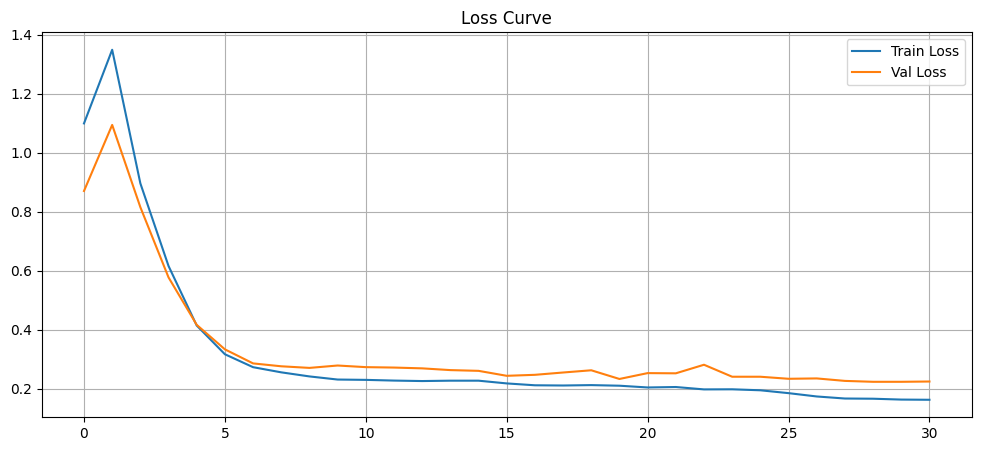

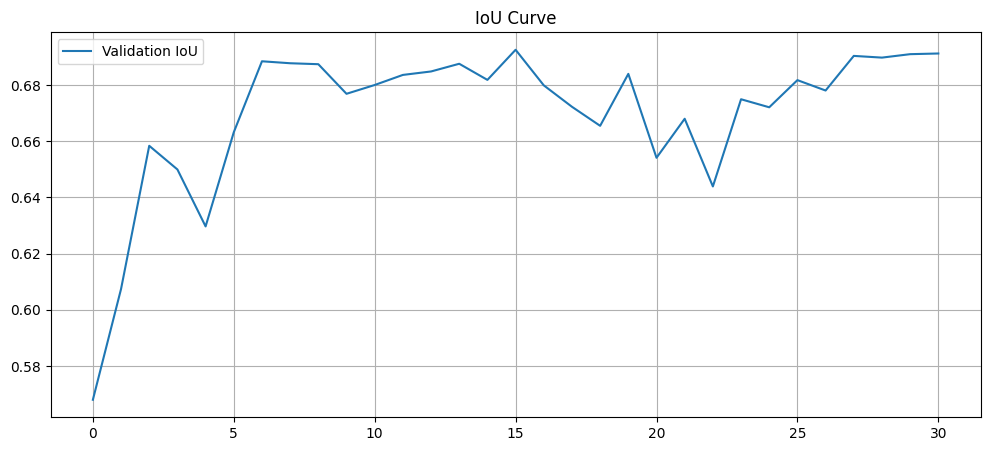

In [ ]:
# ===============================
# 11. PLOT METRICS
# ===============================

history = history_df

plt.figure(figsize=(12,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.grid()
plt.savefig("/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs/unetpp_loss_curve.png")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history["val_iou"], label="Validation IoU")
plt.legend()
plt.title("IoU Curve")
plt.grid()
plt.savefig("/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/unetpp_wbc_efnet_30epochs/unetpp_iou_curve.png")
plt.show()

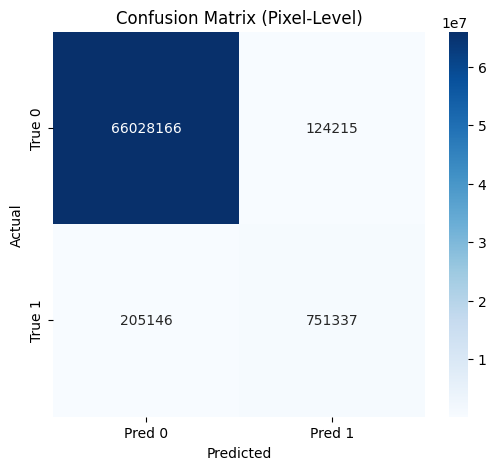

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion_matrix(model, loader):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.unsqueeze(1).float().to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            # Flatten pixel values
            all_preds.append(preds.cpu().numpy().flatten())
            all_targets.append(masks.cpu().numpy().flatten())

    # Combine all batches
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    return cm


# ---- RUN IT ----
cm = compute_confusion_matrix(model, val_loader)

# ---- PLOT ----
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Pixel-Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

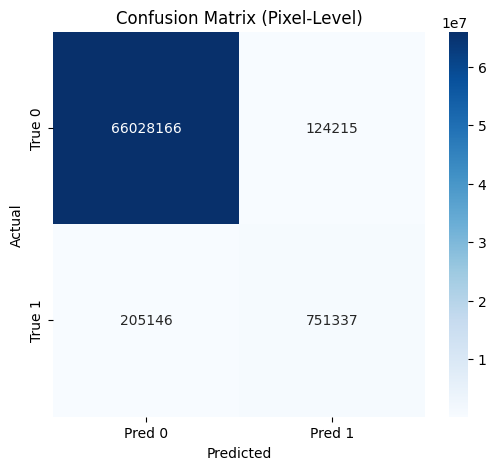

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Pixel-Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig("/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp_efficientnet/confusion_matrix.png")
plt.show()